# Import Packages, Modules, Data

In [61]:
# Import Packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression #Linear regression proc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.feature_selection import RFE #Recursive Feature Elimination -Selects variables based on performance in model.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from scipy.stats import spearmanr # Function to calculate SpearmanR coefficient.
from trueskill import TrueSkill, Rating, rate_1vs1 #Calculate advanced stat (similar to ELO)
import statsmodels.api as sm  

# Any results you write to the current directory are saved as output.
from subprocess import check_output

# Import packages to use for data exploration (graphs/plots)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")
import scipy as sp


# Makes your plots appear in your notebook instead of creating a file somewhere
%matplotlib inline

#Import module to create our training and test sets.
from sklearn.model_selection import train_test_split




In [62]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(check_output(["dir", "/b", "/a-d","Data\Stage2UpdatedDataFiles"], shell=True).decode("utf8"))

Cities.csv
ConferenceTourneyGames.csv
GameCities.csv
NCAATourneyDetailedResults.csv
NCAATourneySeeds.csv
NCAATourneySlots.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmissionStage2.csv
Seasons.csv
TeamCoaches.csv
Teams.csv



In [63]:
# Create Data Frames
# Read csv files into dataframes you can use in you notebook.
data_dir = 'Data/Stage2UpdatedDataFiles/'

# Regular Seasons Stats
df_SeasDetResults = pd.read_csv(data_dir + 'RegularSeasonDetailedResults.csv')

# Regular Seasons Stats
df_TrnDetResults = pd.read_csv(data_dir + 'NCAATourneyDetailedResults.csv')

# Use this to get team name from number
df_teams = pd.read_csv(data_dir + 'Teams.csv')

# Tournament Seeds
df_TournSeeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')



**Check to see if data is in frames**

In [64]:
df_SeasDetResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [65]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [66]:
df_TrnDetResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [67]:
df_TournSeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


# Prep the Regular Season Data

In [68]:
# Merge in win seeds
df_SeasDetResults = df_SeasDetResults.merge(df_TournSeeds, how='left', left_on=['Season', 'WTeamID'], 
                        right_on=['Season', 'TeamID'])

# Rename column for win seed
df_SeasDetResults = df_SeasDetResults.rename(columns={'Seed':'Wseed'})

# Drop Team field 
df_SeasDetResults=df_SeasDetResults.drop(['TeamID'], axis=1)

In [69]:
# Merge in loss seeds
df_SeasDetResults = df_SeasDetResults.merge(df_TournSeeds, how='left', left_on=['Season', 'LTeamID'], 
                        right_on=['Season', 'TeamID'])

# Rename column for loss seed
df_SeasDetResults = df_SeasDetResults.rename(columns={'Seed':'Lseed'})

# Drop Team field 
df_SeasDetResults=df_SeasDetResults.drop(['TeamID'], axis=1)

In [70]:
# Prep Lseed and Wseed columns so that function to parse ints will work.
df_SeasDetResults.fillna(value='Y00', inplace=True)

In [71]:
# Parse int from varchar Wseed field 
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_SeasDetResults['seed'] = df_SeasDetResults.Wseed.apply(seed_to_int)
df_SeasDetResults.drop(labels=['Wseed'], inplace=True, axis=1) # This is the string label

# Rename column for win seed
df_SeasDetResults = df_SeasDetResults.rename(columns={'seed':'Wseed'})

In [72]:
# Parse int from varchar Lseed field
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_SeasDetResults['seed'] = df_SeasDetResults.Lseed.apply(seed_to_int)
df_SeasDetResults.drop(labels=['Lseed'], inplace=True, axis=1) # This is the string label

# Rename column for loss seed
df_SeasDetResults = df_SeasDetResults.rename(columns={'seed':'Lseed'})

#### Don't remove non-seeded games.

The next cell is the main difference between this and the model actually submitted.  The goal here is just to see how we would have done if we had used a larger sample size of games rather than only games with seeded teams against seeded teams -which may have led to issues of small sample size.

Also need to set the WSeed and LSeed NANs to a number.  We'll treat every non-seeded team like a 20-seed.

In [73]:
# Create dataframe for games only of seeded teams vs seeded teams.
df_SeedsOnly = df_SeasDetResults.copy(deep=True)

In [75]:
#Every non-seeded team will be initialized as a 20-seed.  0 would make them a better seed, so we want them to be high.

df_SeedsOnly[['Wseed', 'Lseed']].fillna(20)

df_SeedsOnly[['Wseed', 'Lseed']].replace(to_replace=0, value=20)


,Wseed,Lseed
0,10,1
1,7,3
2,3,20
3,20,20
4,1,20
5,5,20
6,14,20
7,20,20
8,20,20
9,5,20


In [43]:
# Add variable to tell us if this is a tourney game or not.
# Not a predictor, but just in case we want to know later on.
df_SeedsOnly['IsTourneyGame'] = 0

# Prep the Tournament Data

In [44]:
# Checking out the Tournament Detail Results Data Frame
df_TrnDetResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Wseed,Lseed,IsTourneyGame
0,2003,134,1421,92,1411,84,N,1,32,69,...,17,28,16,15,5,0,22,16,16,1
1,2003,136,1112,80,1436,51,N,0,31,66,...,8,26,12,17,10,3,15,1,16,1
2,2003,136,1113,84,1272,71,N,0,31,59,...,20,22,11,12,2,5,18,10,7,1
3,2003,136,1141,79,1166,73,N,0,29,53,...,14,17,20,21,6,6,21,11,6,1
4,2003,136,1143,76,1301,74,N,1,27,64,...,10,26,16,14,5,8,19,8,9,1


In [76]:
# Checking out the Tournament Seeds DataFrame
df_TournSeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [77]:
# Prep Dataframes to be merged
df_TournStats_ToMerge = df_TrnDetResults.copy(deep=True)
df_TournStats_ToMerge.head()

df_TournSeeds_ToMerge = df_TournSeeds.copy(deep=True)
df_TournSeeds_ToMerge.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [78]:
df_TrnDetResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [79]:
# Merge in win seeds
df_TrnDetResults = df_TrnDetResults.merge(df_TournSeeds, how='left', left_on=['Season', 'WTeamID'], 
                        right_on=['Season', 'TeamID'])

# Rename column for win seed
df_TrnDetResults = df_TrnDetResults.rename(columns={'Seed':'Wseed'})

# Drop Team field 
df_TrnDetResults=df_TrnDetResults.drop(['TeamID'], axis=1)

In [80]:
# Merge in loss seeds
df_TrnDetResults = df_TrnDetResults.merge(df_TournSeeds, how='left', left_on=['Season', 'LTeamID'], 
                        right_on=['Season', 'TeamID'])

# Rename column for loss seed
df_TrnDetResults = df_TrnDetResults.rename(columns={'Seed':'Lseed'})

# Drop Team field 
df_TrnDetResults=df_TrnDetResults.drop(['TeamID'], axis=1)

In [81]:
  # Prep Lseed and Wseed columns so that function to parse ints will work.
df_TrnDetResults.fillna(value='Y00', inplace=True)

In [82]:
# Parse int from varchar Wseed field 
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_TrnDetResults['seed'] = df_TrnDetResults.Wseed.apply(seed_to_int)
df_TrnDetResults.drop(labels=['Wseed'], inplace=True, axis=1) # This is the string label

# Rename column for win seed
df_TrnDetResults = df_TrnDetResults.rename(columns={'seed':'Wseed'})

In [52]:
# Parse int from varchar Lseed field
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_TrnDetResults['seed'] = df_TrnDetResults.Lseed.apply(seed_to_int)
df_TrnDetResults.drop(labels=['Lseed'], inplace=True, axis=1) # This is the string label

# Rename column for loss seed
df_TrnDetResults = df_TrnDetResults.rename(columns={'seed':'Lseed'})

TypeError: ("cannot convert the series to <class 'int'>", 'occurred at index Lseed')

In [83]:
# Add variable to tell us if this is a tourney game or not.
# Not a predictor, but just in case we want to know later on.
df_TrnDetResults['IsTourneyGame'] = 1

In [84]:
df_TourneyOnly = df_TrnDetResults

In [85]:
# Concatenate/append/union the regular season and tourney detail data sets together.

df_CombStats = pd.concat([df_SeedsOnly, df_TourneyOnly])



In [86]:
df_CombStats.describe()

,DayNum,IsTourneyGame,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,...,WFGM3,WFTA,WFTM,WOR,WPF,WScore,WStl,WTO,WTeamID,Wseed
count,83022.000000,981.0,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,...,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000,83022.000000
mean,72.155682,1.0,11.435053,2.871227,21.529607,56.302390,19.344836,22.541507,5.998940,18.078847,...,7.028426,22.765833,16.157476,10.967165,17.474742,75.263713,7.025559,13.004649,1287.319265,2.508998
std,35.801265,0.0,3.731163,2.040402,4.528041,7.703921,5.894620,4.384080,2.760744,7.149521,...,3.043109,8.129129,6.254421,4.139191,4.137476,11.136402,3.135877,4.035661,104.831890,4.585080
min,0.000000,1.0,0.000000,0.000000,4.000000,26.000000,1.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,34.000000,0.000000,1.000000,1101.000000,0.000000
25%,40.000000,1.0,9.000000,1.000000,18.000000,51.000000,15.000000,20.000000,4.000000,13.000000,...,5.000000,17.000000,12.000000,8.000000,15.000000,68.000000,5.000000,10.000000,1198.000000,0.000000
50%,75.000000,1.0,11.000000,3.000000,21.000000,56.000000,19.000000,22.000000,6.000000,18.000000,...,7.000000,22.000000,16.000000,11.000000,17.000000,75.000000,7.000000,13.000000,1285.000000,0.000000
75%,103.000000,1.0,14.000000,4.000000,24.000000,61.000000,23.000000,25.000000,8.000000,23.000000,...,9.000000,28.000000,20.000000,14.000000,20.000000,82.000000,9.000000,16.000000,1379.000000,3.000000
max,154.000000,1.0,31.000000,18.000000,49.000000,106.000000,58.000000,47.000000,22.000000,61.000000,...,26.000000,67.000000,48.000000,38.000000,41.000000,144.000000,26.000000,33.000000,1464.000000,16.000000


# Feature Engineering 

In [87]:
# Calculate Number of possessions (complex method)
 
df_CombStats['W_poss'] = df_CombStats['WFGA']+ df_CombStats['WFGA3'] + 0.44 * df_CombStats['WFTA'] - 1.07 * \
                                            (df_CombStats['WOR'] / (df_CombStats['WOR'] + df_CombStats['WDR'])) * \
                                            (df_CombStats['WFGA'] + df_CombStats['WFGA3'] + df_CombStats['WFGM']+ df_CombStats['WFGM3']) + df_CombStats['WTO']
df_CombStats['L_poss'] = df_CombStats['LFGA']+df_CombStats['LFGA3'] + 0.44 * df_CombStats['LFTA'] - 1.07 * \
                                            (df_CombStats['LOR'] / (df_CombStats['LOR'] + df_CombStats['LDR'])) * \
                                            (df_CombStats['LFGA'] + df_CombStats['LFGA3'] + df_CombStats['LFGM'] + df_CombStats['LFGM3']) + df_CombStats['LTO']


In [88]:
# Calculate Number of Posessions (simple method)
# Source:  https://www.burntorangenation.com/2011/10/19/2464697/advanced-basketball-statistics-understanding-possession-estimation

df_CombStats['W_poss2'] = df_CombStats['WFGA']+ 0.475 * df_CombStats['WFTA'] - df_CombStats['WOR']  + df_CombStats['WTO']
df_CombStats['L_poss2'] = df_CombStats['LFGA']+ 0.475 * df_CombStats['LFTA'] - df_CombStats['LOR']  + df_CombStats['LTO']

In [89]:
#Calculate offensive rating and defensive rating

df_CombStats['W_OR'] = 100 * (df_CombStats['WScore']/df_CombStats['W_poss2'])
df_CombStats['L_OR'] = 100 * (df_CombStats['LScore']/df_CombStats['L_poss2'])
df_CombStats['W_DR'] = 100 * (df_CombStats['LScore']/df_CombStats['W_poss2'])
df_CombStats['L_DR'] = 100 * (df_CombStats['WScore']/df_CombStats['L_poss2'])

In [90]:
# True shooting percentage and effective field goal percentage

df_CombStats['W_eFG%']=  (df_CombStats['WFGA'] + df_CombStats['WFGA3'])/(df_CombStats['WFGA']+df_CombStats['WFGA3'])
df_CombStats['L_eFG%']=  (df_CombStats['LFGA'] + df_CombStats['LFGA3'])/(df_CombStats['LFGA']+df_CombStats['LFGA3'])
df_CombStats['W_TSP'] = df_CombStats['WScore'] / (2 * (df_CombStats['WFGA'] + df_CombStats['WFGA3'] + (0.44 * df_CombStats['WFGA'])))
df_CombStats['L_TSP'] = df_CombStats['LScore'] / (2 * (df_CombStats['LFGA'] + df_CombStats['LFGA3'] + (0.44 * df_CombStats['LFGA'])))

In [91]:
#Calculate turnovers per possessions

df_CombStats['W_TO%'] = (df_CombStats['WTO']/df_CombStats['W_poss2'])
df_CombStats['L_TO%'] = (df_CombStats['LTO']/df_CombStats['L_poss2'])

In [92]:
#Calculate free throw percentage

df_CombStats['W_FT%'] = (df_CombStats['WFTM']/df_CombStats['WFTA'])
df_CombStats['L_FT%'] = (df_CombStats['LFTM']/df_CombStats['LFTA'])

In [93]:
#Calculate OREB%

df_CombStats['W_OREB%'] = (df_CombStats['WOR']/(df_CombStats['WOR']+df_CombStats['LDR']))
df_CombStats['L_OREB%'] = (df_CombStats['LOR']/(df_CombStats['LDR']+df_CombStats['WDR']))

In [94]:
#Net Rating = Off.eff - Def.eff

df_CombStats['W_NetRtg'] = df_CombStats.apply(lambda row:(row.W_OR - row.W_DR), axis=1)
df_CombStats['L_NetRtg'] = df_CombStats.apply(lambda row:(row.L_OR - row.W_DR), axis=1)

In [95]:
#Assist Ratio : Percentage of team possessions that end in assists

df_CombStats['W_AstR'] = df_CombStats.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df_CombStats['L_AstR'] = df_CombStats.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)

In [96]:
#FTA Rate : How good a team is at drawing fouls.

df_CombStats['W_FTAR'] = df_CombStats.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df_CombStats['L_FTAR'] = df_CombStats.apply(lambda row: row.LFTA / row.LFGA, axis=1)                         

In [97]:
#OREB% : Percentage of team offensive rebounds

df_CombStats['W_ORP'] = df_CombStats.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_CombStats['L_ORP'] = df_CombStats.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

In [98]:
#DREB% : Percentage of team defensive rebounds

df_CombStats['W_DRP'] = df_CombStats.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_CombStats['L_DRP'] = df_CombStats.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)  

In [99]:
#REB% : Percentage of team total rebounds

df_CombStats['W_RP'] = df_CombStats.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
df_CombStats['L_RP'] = df_CombStats.apply(lambda row: (row.LDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 

PIE : Measure of a team's performance
A high PIE % is highly correlated to winning. In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation

In [100]:
#Points Winning/Losing Team.  For calculating PIE
df_CombStats['W_Pts'] = df_CombStats.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
df_CombStats['L_Pts'] = df_CombStats.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)


#Calculate PIE
df_CombStats['W_PIE'] = df_CombStats.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
wtmp = df_CombStats.apply(lambda row: row.W_Pts + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + 0.5*row.WOR + row.WAst +row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
ltmp = df_CombStats.apply(lambda row: row.L_Pts + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + 0.5*row.LOR + row.LAst +row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1) 
df_CombStats['W_PIE'] = wtmp/(wtmp + ltmp)
df_CombStats['L_PIE'] = ltmp/(wtmp + ltmp)

In [101]:
df_CombStats.head()

,DayNum,IsTourneyGame,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,...,W_ORP,L_ORP,W_DRP,L_DRP,W_RP,L_RP,W_Pts,L_Pts,W_PIE,L_PIE
0,10,NaN,8,2,22,53,10,22,2,22,...,0.388889,0.294118,0.705882,0.611111,0.542857,0.514286,68,62,0.532847,0.467153
1,10,NaN,7,6,25,67,24,24,6,20,...,0.375000,0.416667,0.583333,0.625000,0.488636,0.454545,70,63,0.602339,0.397661
2,11,NaN,9,5,22,73,26,22,3,23,...,0.435897,0.543860,0.456140,0.564103,0.447917,0.406250,73,61,0.736434,0.263566
3,11,NaN,9,3,20,49,22,18,6,15,...,0.230769,0.472222,0.527778,0.769231,0.403226,0.419355,56,50,0.754717,0.245283
4,11,NaN,12,1,15,62,16,24,6,27,...,0.531250,0.488372,0.511628,0.468750,0.520000,0.426667,77,71,0.570732,0.429268


# TrueSkill Rating

#### TrueSkill is a rating system based on Bayesian inference, estimating each players skill as a gaussian-like Elo rating.
#### See trueskill.org for more.

In [102]:
ts = TrueSkill(draw_probability=0.01) # 0.01 is arbitary small number
beta = 25 / 6  # default value


In [103]:
# Create Data Frames
# Read csv files into dataframes you can use in you notebook.
#data_dir = 'Data/DataFiles/'

#df_tour =  pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')

In [104]:
# Change IDs to concatenated Season and TeamID so we can get a ranking for each team in each season.
df_CombStats['WTeamIDSeas'] = df_CombStats['Season'].astype(str) + df_CombStats['WTeamID'].astype(str)
df_CombStats['LTeamIDSeas'] = df_CombStats['Season'].astype(str) + df_CombStats['LTeamID'].astype(str)

In [105]:
df_tour = df_CombStats.copy()

In [106]:
df_tour.head()

,DayNum,IsTourneyGame,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,...,W_DRP,L_DRP,W_RP,L_RP,W_Pts,L_Pts,W_PIE,L_PIE,WTeamIDSeas,LTeamIDSeas
0,10,NaN,8,2,22,53,10,22,2,22,...,0.705882,0.611111,0.542857,0.514286,68,62,0.532847,0.467153,20031104,20031328
1,10,NaN,7,6,25,67,24,24,6,20,...,0.583333,0.625000,0.488636,0.454545,70,63,0.602339,0.397661,20031272,20031393
2,11,NaN,9,5,22,73,26,22,3,23,...,0.456140,0.564103,0.447917,0.406250,73,61,0.736434,0.263566,20031266,20031437
3,11,NaN,9,3,20,49,22,18,6,15,...,0.527778,0.769231,0.403226,0.419355,56,50,0.754717,0.245283,20031296,20031457
4,11,NaN,12,1,15,62,16,24,6,27,...,0.511628,0.468750,0.520000,0.426667,77,71,0.570732,0.429268,20031400,20031208


In [107]:
teamIds = np.unique(np.concatenate([df_tour.WTeamIDSeas.values, df_tour.LTeamIDSeas.values]))
ratings = { tid:ts.Rating() for tid in teamIds }

In [108]:
# Create iterator to calculate TrueSkill for each season.

def feed_season_results(season):
    print("season = {}".format(season))
    df1 = df_tour[df_tour.Season == season]
    for r in df1.itertuples():
        ratings[r.WTeamIDSeas], ratings[r.LTeamIDSeas] = rate_1vs1(ratings[r.WTeamIDSeas], ratings[r.LTeamIDSeas])

In [109]:
# Iterate over each season to update TrueSkill.
# Do this multiple times so that the ratings can refine on each update.
for season in sorted(df_tour.Season.unique()) *30:
    feed_season_results(season)

season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season = 2010
season = 2011
season = 2012
season = 2013
season = 2014
season = 2015
season = 2016
season = 2017
season = 2018
season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season = 2010
season = 2011
season = 2012
season = 2013
season = 2014
season = 2015
season = 2016
season = 2017
season = 2018
season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season = 2010
season = 2011
season = 2012
season = 2013
season = 2014
season = 2015
season = 2016
season = 2017
season = 2018
season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season = 2010
season = 2011
season = 2012
season = 2013
season = 2014
season = 2015
season = 2016
season = 2017
season = 2018
season = 2003
season = 2004
season = 2005
season = 2006
season = 2007
season = 2008
season = 2009
season

In [110]:
# See ratings.  Just for giggles.  The TrueSkill rating is the mu; sigma is the confidence interval.
ratings

{'20061277': trueskill.Rating(mu=34.854, sigma=0.829),
 '20151135': trueskill.Rating(mu=21.691, sigma=0.813),
 '20071387': trueskill.Rating(mu=29.457, sigma=0.814),
 '20101460': trueskill.Rating(mu=28.602, sigma=0.847),
 '20061288': trueskill.Rating(mu=11.039, sigma=0.910),
 '20041163': trueskill.Rating(mu=41.219, sigma=0.909),
 '20061160': trueskill.Rating(mu=32.859, sigma=0.843),
 '20141131': trueskill.Rating(mu=26.853, sigma=0.851),
 '20101140': trueskill.Rating(mu=36.525, sigma=0.924),
 '20121399': trueskill.Rating(mu=24.594, sigma=0.836),
 '20121412': trueskill.Rating(mu=27.743, sigma=0.827),
 '20151212': trueskill.Rating(mu=-4.957, sigma=1.776),
 '20131385': trueskill.Rating(mu=30.152, sigma=0.828),
 '20071197': trueskill.Rating(mu=21.605, sigma=0.856),
 '20101133': trueskill.Rating(mu=29.257, sigma=0.810),
 '20061229': trueskill.Rating(mu=24.501, sigma=0.856),
 '20061243': trueskill.Rating(mu=29.701, sigma=0.812),
 '20041253': trueskill.Rating(mu=18.444, sigma=0.852),
 '20161254

In [111]:
# Pull the ratings and the keys and ratings from the results of the iterator and combine in a df.
keys = ratings.keys()
rate = [r.mu for r in ratings.values()]

df_trueskill = pd.DataFrame()
df_trueskill['TeamSeasID']= keys
df_trueskill['TSRating'] = rate

In [112]:
# Parse the TeamID and Team Name so we can join it back to the data set.
df_trueskill['Season'] = df_trueskill['TeamSeasID'].str[:4]
df_trueskill['TeamID'] = df_trueskill['TeamSeasID'].str[4:]


In [113]:
df_trueskill.head()

,TeamSeasID,TSRating,Season,TeamID
0,20061277,34.854380,2006,1277
1,20151135,21.691137,2015,1135
2,20071387,29.457220,2007,1387
3,20101460,28.602262,2010,1460
4,20061288,11.039492,2006,1288


In [114]:
# Merge in win trueskill rating
df_CombStats = df_CombStats.merge(df_trueskill, how='left', left_on=['WTeamIDSeas'], 
                        right_on=['TeamSeasID'])

In [115]:
df_CombStats.head()

,DayNum,IsTourneyGame,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,...,W_Pts,L_Pts,W_PIE,L_PIE,WTeamIDSeas,LTeamIDSeas,TeamSeasID,TSRating,Season_y,TeamID
0,10,NaN,8,2,22,53,10,22,2,22,...,68,62,0.532847,0.467153,20031104,20031328,20031104,32.639408,2003,1104
1,10,NaN,7,6,25,67,24,24,6,20,...,70,63,0.602339,0.397661,20031272,20031393,20031272,34.607294,2003,1272
2,11,NaN,9,5,22,73,26,22,3,23,...,73,61,0.736434,0.263566,20031266,20031437,20031266,38.062614,2003,1266
3,11,NaN,9,3,20,49,22,18,6,15,...,56,50,0.754717,0.245283,20031296,20031457,20031296,27.607137,2003,1296
4,11,NaN,12,1,15,62,16,24,6,27,...,77,71,0.570732,0.429268,20031400,20031208,20031400,38.109541,2003,1400


In [116]:
# Drop extra fields
df_CombStats.drop(['TeamSeasID', 'Season_y', 'TeamID'],  inplace=True, axis=1)

# Rename column for win trueskill
df_CombStats = df_CombStats.rename(columns={'TSRating':'W_TSRating'})

In [117]:
# Merge in lose trueskill rating
df_CombStats = df_CombStats.merge(df_trueskill, how='left', left_on=['LTeamIDSeas'], 
                        right_on=['TeamSeasID'])

In [118]:
# Drop extra fields
df_CombStats.drop(['TeamSeasID', 'Season', 'TeamID'],  inplace=True, axis=1)

# Rename column for win trueskill
df_CombStats = df_CombStats.rename(columns={'TSRating':'L_TSRating', 'Season_x':'Season'})

In [119]:
df_CombStats.head()

,DayNum,IsTourneyGame,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,...,W_RP,L_RP,W_Pts,L_Pts,W_PIE,L_PIE,WTeamIDSeas,LTeamIDSeas,W_TSRating,L_TSRating
0,10,NaN,8,2,22,53,10,22,2,22,...,0.542857,0.514286,68,62,0.532847,0.467153,20031104,20031328,32.639408,38.112930
1,10,NaN,7,6,25,67,24,24,6,20,...,0.488636,0.454545,70,63,0.602339,0.397661,20031272,20031393,34.607294,39.847563
2,11,NaN,9,5,22,73,26,22,3,23,...,0.447917,0.406250,73,61,0.736434,0.263566,20031266,20031437,38.062614,29.955710
3,11,NaN,9,3,20,49,22,18,6,15,...,0.403226,0.419355,56,50,0.754717,0.245283,20031296,20031457,27.607137,23.519901
4,11,NaN,12,1,15,62,16,24,6,27,...,0.520000,0.426667,77,71,0.570732,0.429268,20031400,20031208,38.109541,36.545631


# Final Data Prep

#### Drop unneeded variables
#### Separate Test and Training Sets
#### Calculate differentials for winners and losers and add Result column (this is the target)
#### Remove all outliers more than 3 std from the mean
#### Aggregate by season
#### 
#### 

In [120]:
# Copy df to make starting over easier.

df_CombStats2 = df_CombStats.copy()

In [121]:
# Drop extra fields
df_CombStats2.drop(['DayNum', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 
                   'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                   'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                   'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                   'IsTourneyGame'
                  ],  inplace=True, axis=1)

In [122]:
# Split data into wins and losses to be concatenated in order to get averages.  

df_WinAgg = df_CombStats2.copy()

df_WinAgg.drop(['LTeamID', 'LScore', 'Lseed', 'L_poss', 'L_poss2', 'L_OR', 'L_DR', 'L_eFG%', 
                   'L_TSP', 'L_TO%', 'L_FT%', 'L_OREB%', 'L_NetRtg', 'L_AstR', 'L_FTAR', 'L_ORP',
                   'L_DRP', 'L_RP', 'L_Pts', 'L_PIE', 'L_TSRating','LTeamIDSeas' 
                  ],  inplace=True, axis=1)

df_LoseAgg = df_CombStats2.copy()

df_LoseAgg.drop(['WTeamID', 'WScore', 'Wseed', 'W_poss', 'W_poss2', 'W_OR', 'W_DR', 'W_eFG%', 
                   'W_TSP', 'W_TO%', 'W_FT%', 'W_OREB%', 'W_NetRtg', 'W_AstR', 'W_FTAR', 'W_ORP',
                   'W_DRP', 'W_RP', 'W_Pts', 'W_PIE', 'W_TSRating','WTeamIDSeas' 
                  ],  inplace=True, axis=1)


In [123]:
# Rename columns in win and lose aggs in order to concatenate.

df_WinAgg = df_WinAgg.rename(columns={'WTeamID':'TeamID', 'WScore':'Score', 'Wseed':'Seed', 'W_poss':'Poss', 'W_poss2':'Poss2',
                                      'W_OR':'OR', 'W_DR':'DR', 'W_eFG%':'eFGP','W_TSP':'TSP', 'W_TO%':'TOP', 'W_FT%':'FTP',
                                      'W_OREB%':'ORebP', 'W_NetRtg':'NetRtg', 'W_AstR':'AstR', 'W_FTAR':'FTAR', 'W_ORP':'ORP',
                                      'W_DRP':'DRP', 'W_RP':'RP', 'W_Pts':'Pts', 'W_PIE':'PIE', 'W_TSRating':'TSRtg',
                                      'WTeamIDSeas':'TeamIDSeas'})

df_LoseAgg = df_LoseAgg.rename(columns={'LTeamID':'TeamID', 'LScore':'Score', 'Lseed':'Seed', 'L_poss':'Poss', 'L_poss2':'Poss2',
                                      'L_OR':'OR', 'L_DR':'DR', 'L_eFG%':'eFGP','L_TSP':'TSP', 'L_TO%':'TOP', 'L_FT%':'FTP',
                                      'L_OREB%':'ORebP', 'L_NetRtg':'NetRtg', 'L_AstR':'AstR', 'L_FTAR':'FTAR', 'L_ORP':'ORP',
                                      'L_DRP':'DRP', 'L_RP':'RP', 'L_Pts':'Pts', 'L_PIE':'PIE', 'L_TSRating':'TSRtg',
                                      'LTeamIDSeas':'TeamIDSeas'})

In [124]:
# Append win/loss stats so we have all stats for every game, win or lose, for each team on separate rows.
# Append is the same as Union in SQL
# The product of this is what we can aggregate.

df_AggStats = df_WinAgg.append(df_LoseAgg)

Handling Outliers

In [125]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['Score'].mean() + (df_AggStats['Score'].std() *3)
MinVal = df_AggStats['Score'].mean() - (df_AggStats['OR'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['Score'] > MaxVal, 'Score'] = MaxVal
df_AggStats.loc[df_AggStats['Score'] < MinVal, 'Score'] = MinVal

In [126]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['Poss'].mean() + (df_AggStats['Poss'].std() *3)
MinVal = df_AggStats['Poss'].mean() - (df_AggStats['Poss'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['Poss'] > MaxVal, 'Poss'] = MaxVal
df_AggStats.loc[df_AggStats['Poss'] < MinVal, 'Poss'] = MinVal

In [127]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['Poss2'].mean() + (df_AggStats['Poss2'].std() *3)
MinVal = df_AggStats['Poss2'].mean() - (df_AggStats['Poss2'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['Poss2'] > MaxVal, 'Poss2'] = MaxVal
df_AggStats.loc[df_AggStats['Poss2'] < MinVal, 'Poss2'] = MinVal

In [128]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['OR'].mean() + (df_AggStats['OR'].std() *3)
MinVal = df_AggStats['OR'].mean() - (df_AggStats['OR'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['OR'] > MaxVal, 'OR'] = MaxVal
df_AggStats.loc[df_AggStats['OR'] < MinVal, 'OR'] = MinVal

In [129]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['eFGP'].mean() + (df_AggStats['eFGP'].std() *3)
MinVal = df_AggStats['eFGP'].mean() - (df_AggStats['eFGP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['eFGP'] > MaxVal, 'eFGP'] = MaxVal
df_AggStats.loc[df_AggStats['eFGP'] < MinVal, 'eFGP'] = MinVal

In [130]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['TSP'].mean() + (df_AggStats['TSP'].std() *3)
MinVal = df_AggStats['TSP'].mean() - (df_AggStats['TSP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['TSP'] > MaxVal, 'TSP'] = MaxVal
df_AggStats.loc[df_AggStats['TSP'] < MinVal, 'TSP'] = MinVal

In [131]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['TOP'].mean() + (df_AggStats['TOP'].std() *3)
MinVal = df_AggStats['TOP'].mean() - (df_AggStats['TOP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['TOP'] > MaxVal, 'TOP'] = MaxVal
df_AggStats.loc[df_AggStats['TOP'] < MinVal, 'TOP'] = MinVal

In [132]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['FTP'].mean() + (df_AggStats['FTP'].std() *3)
MinVal = df_AggStats['FTP'].mean() - (df_AggStats['FTP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['FTP'] > MaxVal, 'FTP'] = MaxVal
df_AggStats.loc[df_AggStats['FTP'] < MinVal, 'FTP'] = MinVal

In [133]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['ORebP'].mean() + (df_AggStats['ORebP'].std() *3)
MinVal = df_AggStats['ORebP'].mean() - (df_AggStats['ORebP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['ORebP'] > MaxVal, 'ORebP'] = MaxVal
df_AggStats.loc[df_AggStats['ORebP'] < MinVal, 'ORebP'] = MinVal

In [134]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['NetRtg'].mean() + (df_AggStats['NetRtg'].std() *3)
MinVal = df_AggStats['NetRtg'].mean() - (df_AggStats['NetRtg'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['NetRtg'] > MaxVal, 'NetRtg'] = MaxVal
df_AggStats.loc[df_AggStats['NetRtg'] < MinVal, 'NetRtg'] = MinVal

In [135]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['AstR'].mean() + (df_AggStats['AstR'].std() *3)
MinVal = df_AggStats['AstR'].mean() - (df_AggStats['AstR'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['AstR'] > MaxVal, 'AstR'] = MaxVal
df_AggStats.loc[df_AggStats['AstR'] < MinVal, 'AstR'] = MinVal

In [136]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['FTAR'].mean() + (df_AggStats['FTAR'].std() *3)
MinVal = df_AggStats['FTAR'].mean() - (df_AggStats['FTAR'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['FTAR'] > MaxVal, 'FTAR'] = MaxVal
df_AggStats.loc[df_AggStats['FTAR'] < MinVal, 'FTAR'] = MinVal

In [137]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['ORP'].mean() + (df_AggStats['ORP'].std() *3)
MinVal = df_AggStats['ORP'].mean() - (df_AggStats['ORP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['ORP'] > MaxVal, 'ORP'] = MaxVal
df_AggStats.loc[df_AggStats['ORP'] < MinVal, 'ORP'] = MinVal

In [138]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['DRP'].mean() + (df_AggStats['DRP'].std() *3)
MinVal = df_AggStats['DRP'].mean() - (df_AggStats['DRP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['DRP'] > MaxVal, 'DRP'] = MaxVal
df_AggStats.loc[df_AggStats['DRP'] < MinVal, 'DRP'] = MinVal

In [139]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['RP'].mean() + (df_AggStats['RP'].std() *3)
MinVal = df_AggStats['RP'].mean() - (df_AggStats['RP'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['RP'] > MaxVal, 'RP'] = MaxVal
df_AggStats.loc[df_AggStats['RP'] < MinVal, 'RP'] = MinVal

In [140]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['Pts'].mean() + (df_AggStats['Pts'].std() *3)
MinVal = df_AggStats['Pts'].mean() - (df_AggStats['Pts'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['Pts'] > MaxVal, 'Pts'] = MaxVal
df_AggStats.loc[df_AggStats['Pts'] < MinVal, 'Pts'] = MinVal

In [141]:
# Determine the top and bottom threshold for outliers.
MaxVal = df_AggStats['PIE'].mean() + (df_AggStats['PIE'].std() *3)
MinVal = df_AggStats['PIE'].mean() - (df_AggStats['PIE'].std() *3)

# Update outliers to equal the threshold values.
df_AggStats.loc[df_AggStats['PIE'] > MaxVal, 'PIE'] = MaxVal
df_AggStats.loc[df_AggStats['PIE'] < MinVal, 'PIE'] = MinVal

Average, Aggregate and Combine

In [142]:
# Create new df with averaged all team season stats
# The reset_index is key so that I can join later using that column.

df_AggStats2 = df_AggStats.groupby('TeamIDSeas', axis=0).mean().reset_index()

In [143]:
# Get win and loss team ID for each game in order to recombine with aggregated season stats. 

df_WinLoss = df_CombStats2[['Season', 'WTeamID', 'LTeamID', 'WTeamIDSeas', 'LTeamIDSeas']]


In [144]:
# Merge the average team stats for the win team.
df_WinLoss = pd.merge(df_WinLoss, df_AggStats2, left_on='WTeamIDSeas', right_on='TeamIDSeas')


In [145]:
# Clean up columns, and rename stats so they can be identified as the win team stats.
df_WinLoss.drop(['Season_y', 'TeamID'],  inplace=True, axis=1)

df_WinLoss = df_WinLoss.rename(columns={'Score':'WScore', 'Seed':'WSeed', 'Poss':'WPoss', 'Poss2':'WPoss2',
                                      'OR':'WOR', 'DR':'WDR', 'eFGP':'WeFGP','TSP':'WTSP', 'TOP':'WTOP', 'FTP':'WFTP',
                                      'ORebP':'WORebP', 'NetRtg':'WNetRtg', 'AstR':'WAstR', 'FTAR':'WFTAR', 'ORP':'WORP',
                                      'DRP':'WDRP', 'RP':'WRP', 'Pts':'WPts', 'PIE':'WPIE', 'TSRtg':'WTSRtg',
                                      'TeamIDSeas':'WTeamIDSeas'})

In [146]:
# Repeat steps above for losing team with a copy of df_WinLoss so it doesn't overwrite our changes.

df_WinLoss2 = df_WinLoss.copy()

df_WinLoss2 = pd.merge(df_WinLoss2, df_AggStats2, left_on='LTeamIDSeas', right_on='TeamIDSeas')

df_WinLoss2.drop(['Season_y', 'TeamID'],  inplace=True, axis=1)

df_WinLoss2 = df_WinLoss2.rename(columns={'Score':'LScore', 'Seed':'LSeed', 'Poss':'LPoss', 'Poss2':'LPoss2',
                                      'OR':'LOR', 'DR':'LDR', 'eFGP':'LeFGP','TSP':'LTSP', 'TOP':'LTOP', 'FTP':'LFTP',
                                      'ORebP':'LORebP', 'NetRtg':'LNetRtg', 'AstR':'LAstR', 'FTAR':'LFTAR', 'ORP':'LORP',
                                      'DRP':'LDRP', 'RP':'LRP', 'Pts':'LPts', 'PIE':'LPIE', 'TSRtg':'LTSRtg',
                                      'TeamIDSeas':'LTeamIDSeas'})

Calculate Differentials

In [148]:
# Winner Stats
# if you set a dataframe = to another dataframe it will modify the the original data frame.  
# Use copy to preserve and not accidentally do bad things and upset yourself later
df_WinnerStats = df_WinLoss2.copy(deep=True)

# Calculate Differentials
#Also add a column called Result and set it to =1 for all winning rows.  This is our target variable for predication.  
df_WinnerStats['diff_Score'] = df_WinLoss2.WScore  - df_WinLoss2.LScore 
#df_WinnerStats['diff_Seed'] = df_WinLoss2.WSeed   - df_WinLoss2.LSeed  
df_WinnerStats['diff_Poss'] = df_WinLoss2.WPoss   - df_WinLoss2.LPoss  
df_WinnerStats['diff_Poss2'] = df_WinLoss2.WPoss2  - df_WinLoss2.LPoss2 
df_WinnerStats['diff_OR'] = df_WinLoss2.WOR     - df_WinLoss2.LOR    
df_WinnerStats['diff_DR'] = df_WinLoss2.WDR     - df_WinLoss2.LDR    
df_WinnerStats['diff_eFGP'] = df_WinLoss2.WeFGP   - df_WinLoss2.LeFGP  
df_WinnerStats['diff_TSP'] = df_WinLoss2.WTSP    - df_WinLoss2.LTSP   
df_WinnerStats['diff_TOP'] = df_WinLoss2.WTOP    - df_WinLoss2.LTOP   
df_WinnerStats['diff_FTP'] = df_WinLoss2.WFTP    - df_WinLoss2.LFTP   
df_WinnerStats['diff_ORebP'] = df_WinLoss2.WORebP  - df_WinLoss2.LORebP 
df_WinnerStats['diff_NetRtg'] = df_WinLoss2.WNetRtg - df_WinLoss2.LNetRtg
df_WinnerStats['diff_AstR'] = df_WinLoss2.WAstR   - df_WinLoss2.LAstR  
df_WinnerStats['diff_FTAR'] = df_WinLoss2.WFTAR   - df_WinLoss2.LFTAR  
df_WinnerStats['diff_ORP'] = df_WinLoss2.WORP    - df_WinLoss2.LORP   
df_WinnerStats['diff_DRP'] = df_WinLoss2.WDRP    - df_WinLoss2.LDRP   
df_WinnerStats['diff_RP'] = df_WinLoss2.WRP     - df_WinLoss2.LRP    
df_WinnerStats['diff_Pts'] = df_WinLoss2.WPts    - df_WinLoss2.LPts   
df_WinnerStats['diff_PIE'] = df_WinLoss2.WPIE    - df_WinLoss2.LPIE   
df_WinnerStats['diff_TSRtg'] = df_WinLoss2.WTSRtg  - df_WinLoss2.LTSRtg 
df_WinnerStats['Result'] = 1

In [149]:
# Same as above for Loser Stats

df_LoserStats = df_WinLoss2.copy(deep=True)

df_LoserStats['diff_Score'] = df_WinLoss2.LScore  - df_WinLoss2.WScore 
#df_LoserStats['diff_Seed'] = df_WinLoss2.LSeed   - df_WinLoss2.WSeed  
df_LoserStats['diff_Poss'] = df_WinLoss2.LPoss   - df_WinLoss2.WPoss  
df_LoserStats['diff_Poss2'] = df_WinLoss2.LPoss2  - df_WinLoss2.WPoss2 
df_LoserStats['diff_OR'] = df_WinLoss2.LOR     - df_WinLoss2.WOR    
df_LoserStats['diff_DR'] = df_WinLoss2.LDR     - df_WinLoss2.WDR    
df_LoserStats['diff_eFGP'] = df_WinLoss2.LeFGP   - df_WinLoss2.WeFGP  
df_LoserStats['diff_TSP'] = df_WinLoss2.LTSP    - df_WinLoss2.WTSP   
df_LoserStats['diff_TOP'] = df_WinLoss2.LTOP    - df_WinLoss2.WTOP   
df_LoserStats['diff_FTP'] = df_WinLoss2.LFTP    - df_WinLoss2.WFTP   
df_LoserStats['diff_ORebP'] = df_WinLoss2.LORebP  - df_WinLoss2.WORebP 
df_LoserStats['diff_NetRtg'] = df_WinLoss2.LNetRtg - df_WinLoss2.WNetRtg
df_LoserStats['diff_AstR'] = df_WinLoss2.LAstR   - df_WinLoss2.WAstR  
df_LoserStats['diff_FTAR'] = df_WinLoss2.LFTAR   - df_WinLoss2.WFTAR  
df_LoserStats['diff_ORP'] = df_WinLoss2.LORP    - df_WinLoss2.WORP   
df_LoserStats['diff_DRP'] = df_WinLoss2.LDRP    - df_WinLoss2.WDRP   
df_LoserStats['diff_RP'] = df_WinLoss2.LRP     - df_WinLoss2.WRP    
df_LoserStats['diff_Pts'] = df_WinLoss2.LPts    - df_WinLoss2.WPts   
df_LoserStats['diff_PIE'] = df_WinLoss2.LPIE    - df_WinLoss2.WPIE   
df_LoserStats['diff_TSRtg'] = df_WinLoss2.LTSRtg  - df_WinLoss2.WTSRtg 
df_LoserStats['Result'] = 0

In [150]:
# Append win/loss stats so we have all our differentials, other stats, and target variable for all wins and losses on separate 
#rows in the same data set.
# Append is the same as Union in SQL

concats = [df_WinnerStats, df_LoserStats]
df_Concats = df_WinnerStats.append(df_LoserStats)
df_Concats.head()

,Season_x,WTeamID,LTeamID,WTeamIDSeas,LTeamIDSeas,WTeamIDSeas,WAstR,WDR,WDRP,WFTAR,...,diff_NetRtg,diff_AstR,diff_FTAR,diff_ORP,diff_DRP,diff_RP,diff_Pts,diff_PIE,diff_TSRtg,Result
0,2003,1104,1328,20031104,20031328,20031104,13.206729,98.143378,0.684110,0.370120,...,-6.827267,-2.193528,0.037741,0.013162,-0.025952,-0.022757,-1.318458,-0.064888,-5.473522,1
1,2003,1400,1328,20031400,20031328,20031400,14.228031,98.084149,0.670017,0.408536,...,-1.893843,-1.172226,0.076157,0.063164,-0.040045,0.010629,8.980392,0.013874,-0.003390,1
2,2003,1400,1328,20031400,20031328,20031400,14.228031,98.084149,0.670017,0.408536,...,-1.893843,-1.172226,0.076157,0.063164,-0.040045,0.010629,8.980392,0.013874,-0.003390,1
3,2003,1281,1328,20031281,20031328,20031281,14.313955,98.974233,0.672007,0.310401,...,-4.866889,-1.086302,-0.021977,0.006812,-0.038055,-0.016908,2.040998,-0.043975,-2.813021,1
4,2003,1329,1328,20031329,20031328,20031329,13.225583,91.138019,0.647978,0.411614,...,-3.917054,-2.174674,0.079235,0.002150,-0.062084,-0.024124,-1.772296,-0.015740,-3.476138,1


In [151]:
#Drop unneeded/unwanted columns.
df_Concats.drop(labels=[ 'WScore', 'LScore', 'WSeed', 'LSeed', 'WPoss', 'LPoss', 'WPoss2', 'LPoss2',
 'WOR', 'LOR', 'WDR', 'LDR', 'WeFGP', 'LeFGP', 'WTSP', 'LTSP', 'WTOP', 'LTOP',
 'WFTP', 'LFTP', 'WORebP', 'LORebP', 'WNetRtg', 'LNetRtg', 'WAstR', 'LAstR',
 'WFTAR', 'LFTAR', 'WORP', 'LORP', 'WDRP', 'LDRP', 'WRP', 'LRP', 'WPts', 'LPts',
 'WPIE', 'LPIE', 'WTSRtg', 'LTSRtg'],inplace=True, axis=1)

In [152]:
df_Concats.describe()

,Season_x,WTeamID,LTeamID,Season,diff_Score,diff_Poss,diff_Poss2,diff_OR,diff_DR,diff_eFGP,...,diff_NetRtg,diff_AstR,diff_FTAR,diff_ORP,diff_DRP,diff_RP,diff_Pts,diff_PIE,diff_TSRtg,Result
count,166044.000000,166044.000000,166044.000000,166044.000000,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,166044.0,...,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,1.660440e+05,166044.000000
mean,2010.727373,1287.319265,1281.826492,2010.727373,-1.079259e-14,9.590641e-16,-2.609483e-16,4.778546e-15,1.449448e-14,0.0,...,2.354520e-14,1.626220e-15,3.617599e-17,-5.450737e-17,-2.296884e-17,2.910822e-17,-9.028862e-15,-5.189325e-16,-2.939430e-14,0.500000
std,4.560599,104.831575,103.978001,4.560599,7.369506e+00,5.328301e+00,4.187543e+00,8.523270e+00,7.081907e+00,0.0,...,6.476623e+00,2.252904e+00,6.873209e-02,5.279788e-02,3.867206e-02,2.998146e-02,7.365695e+00,1.049251e-01,7.411911e+00,0.500002
min,2003.000000,1101.000000,1101.000000,2003.000000,-4.422579e+01,-2.671698e+01,-3.040532e+01,-4.158582e+01,-3.348612e+01,0.0,...,-2.769124e+01,-1.001012e+01,-2.944752e-01,-2.346302e-01,-1.788213e-01,-1.368045e-01,-4.422579e+01,-4.978325e-01,-4.584237e+01,0.000000
25%,2007.000000,1198.000000,1191.000000,2007.000000,-4.933333e+00,-3.494983e+00,-2.708576e+00,-5.688079e+00,-4.720557e+00,0.0,...,-4.221042e+00,-1.512641e+00,-4.644358e-02,-3.483898e-02,-2.605429e-02,-2.012798e-02,-4.932414e+00,-6.985815e-02,-4.549784e+00,0.000000
50%,2011.000000,1285.000000,1280.000000,2011.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000
75%,2015.000000,1379.000000,1373.000000,2015.000000,4.933333e+00,3.494983e+00,2.708576e+00,5.688079e+00,4.720557e+00,0.0,...,4.221042e+00,1.512641e+00,4.644358e-02,3.483898e-02,2.605429e-02,2.012798e-02,4.932414e+00,6.985815e-02,4.549784e+00,1.000000
max,2018.000000,1464.000000,1464.000000,2018.000000,4.422579e+01,2.671698e+01,3.040532e+01,4.158582e+01,3.348612e+01,0.0,...,2.769124e+01,1.001012e+01,2.944752e-01,2.346302e-01,1.788213e-01,1.368045e-01,4.422579e+01,4.978325e-01,4.584237e+01,1.000000


Create Test and Training Sets (Should be saved to CSV to make permanent, but hey...)

In [153]:
# Create training and test sets for the data.
# df_train is the test set.  Use this one for analysis.
# df_test is the test set.  Don't do anything to this one for now.

df_train, df_test = train_test_split(df_Concats, test_size=0.33)

# Model Selection

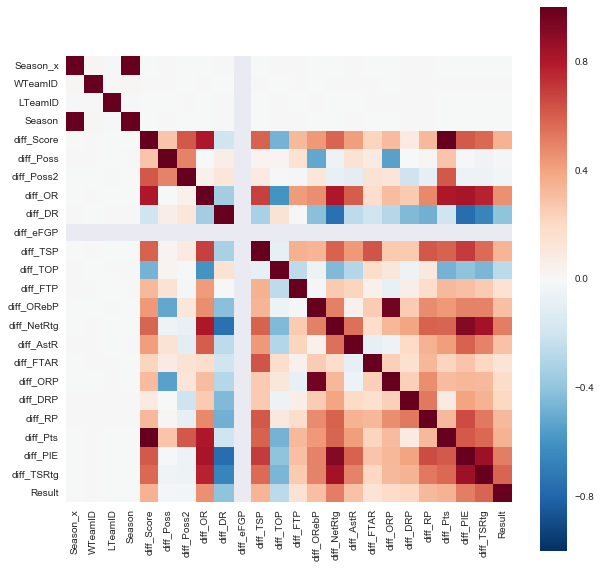

In [154]:
# Correlation heatmap

# Set size of plot so that it's readable
plt.figure(figsize=(10, 10))

# Produce heatmap
sns.heatmap(df_train.corr(), square=True)

In [155]:
#Create an array with all possible variables in it except the target. 
data_variables=df_train.columns.values.tolist()
y=['Result']
X=[i for i in data_variables if i not in y]

print(X)

['Season_x', 'WTeamID', 'LTeamID', 'WTeamIDSeas', 'LTeamIDSeas', 'WTeamIDSeas', 'LTeamIDSeas', 'Season', 'diff_Score', 'diff_Poss', 'diff_Poss2', 'diff_OR', 'diff_DR', 'diff_eFGP', 'diff_TSP', 'diff_TOP', 'diff_FTP', 'diff_ORebP', 'diff_NetRtg', 'diff_AstR', 'diff_FTAR', 'diff_ORP', 'diff_DRP', 'diff_RP', 'diff_Pts', 'diff_PIE', 'diff_TSRtg']


In [156]:
# Add selected columns to a new array.
cols=['diff_TSP', 'diff_NetRtg', 'diff_TSRtg']
X=df_train[cols]
y=df_train['Result']

In [157]:
# Run model with Statsmodels API
import statsmodels.api as sm  
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.473879
         Iterations 7
                          Results: Logit
Model:              Logit            No. Iterations:   7.0000     
Dependent Variable: Result           Pseudo R-squared: 0.316      
Date:               2018-03-17 15:55 AIC:              105443.2205
No. Observations:   111249           BIC:              105472.0791
Df Model:           2                Log-Likelihood:   -52719.    
Df Residuals:       111246           LL-Null:          -77112.    
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025  0.975]
-------------------------------------------------------------------
diff_TSP       -0.2730    0.3034   -0.8998  0.3682  -0.8676  0.3216
diff_NetRtg    -0.0021    0.0024   -0.8674  0.3857  -0.0068  0.0026
diff_TSRtg      0.2744    0.0026  104.5714  0.00

In [182]:
# Use SKLearn to prep data for some diagnostics and fit testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
# Accuracy is the proportion of true positives and true negatives vs false positives and false negatives.
# In your confusin matrix, it's top-left + bottom-right / total.
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [180]:
#10-Fold Cross-Validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.762


In [161]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[12840  3959]
 [ 3885 12691]]


In [162]:
# Calculate Precision, Recall, F-Measure and Support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.76      0.77     16799
          1       0.76      0.77      0.76     16576

avg / total       0.76      0.76      0.76     33375



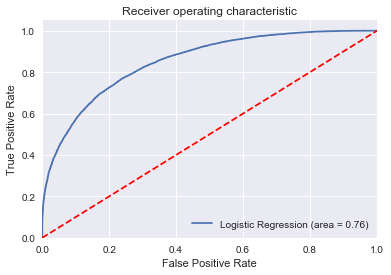

In [163]:
# ROC Curve
# The ROC curve measures the tradeoff between selecting as many True Positives as possible while avoiding False Positives.
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Actual Predictions

In [165]:
# Get submission and teams csv.  Initialize in df.

df_predict = pd.read_csv(data_dir + 'SampleSubmissionStage2.csv')
df_teams = pd.read_csv(data_dir + 'Teams.csv')

In [166]:
# Parse the IDs from the submission file.

def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

for row in df_predict.itertuples():
    year, t1, t2 = get_year_t1_t2(row.ID)
    idx = row.Index
    df_predict.at[idx, 'Year'] = year
    df_predict.at[idx, 'Wteam'] = t1
    df_predict.at[idx, 'Lteam'] = t2

In [167]:
# Grab the data from before differentials were calculated to make the model, and use it to prep the new data.\
# Will need to get all the aggregated stats connected for the matchups in the tournament in order to predict the new games.
# This is basically prepping for what is called "out of sample" prediction.  
  # Meaning, now we're predicting stuff that wasn't in the original data sample we built the model on.  These are actual predictions.

predcats = [df_WinnerStats, df_LoserStats]
predcats = df_WinnerStats.append(df_LoserStats)
predcats.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 166044 entries, 0 to 83021
Data columns (total 66 columns):
Season_x       166044 non-null int64
WTeamID        166044 non-null int64
LTeamID        166044 non-null int64
WTeamIDSeas    166044 non-null object
LTeamIDSeas    166044 non-null object
WTeamIDSeas    166044 non-null object
WAstR          166044 non-null float64
WDR            166044 non-null float64
WDRP           166044 non-null float64
WFTAR          166044 non-null float64
WFTP           166044 non-null float64
WNetRtg        166044 non-null float64
WOR            166044 non-null float64
WORP           166044 non-null float64
WORebP         166044 non-null float64
WPIE           166044 non-null float64
WPoss          166044 non-null float64
WPoss2         166044 non-null float64
WPts           166044 non-null float64
WRP            166044 non-null float64
WScore         166044 non-null float64
WTOP           166044 non-null float64
WTSP           166044 non-null float64
WT

In [168]:
# Take only columns we need for calculating the differentials our model uses as features.
predcats2 = predcats[['Season', 'WTeamID', 'LTeamID', 'WTSP','WNetRtg','WTSRtg', 
                       'LTSP','LNetRtg','LTSRtg']]

In [169]:
# Filter to only take 2018 data because only 2018 teams are int he tourney.
predcats3 = predcats2.loc[predcats2['Season'] == 2018]

In [170]:
# Merge win team aggregated 2018 data
df_predict = df_predict.merge(predcats3, how='left', left_on=['Year', 'Wteam'], 
                        right_on=['Season', 'WTeamID'])

In [171]:
# Merge lose team aggregated 2018 data
df_predict = df_predict.merge(predcats3, how='left', left_on=['Year', 'Lteam'], 
                        right_on=['Season', 'LTeamID'])

In [172]:
# Drop unneeded columns.
df_predict = df_predict[['ID', 'Year', 'Wteam', 'Lteam', 'WTSP_x', 'WNetRtg_x', 'WTSRtg_x', 
                         'LTSP_y', 'LNetRtg_y', 'LTSRtg_y']]

In [173]:
# Calculate differentials for each of the matchups.
df_predict['diff_TSP'] = df_predict['WTSP_x'] - df_predict['LTSP_y']
df_predict['diff_NetRtg'] = df_predict['WNetRtg_x'] - df_predict['LNetRtg_y']
df_predict['diff_TSRtg'] = df_predict['WTSRtg_x'] - df_predict['LTSRtg_y']


In [174]:
# The above appeared to give a cartesian product, so drop the extra duplicate columns that showed up.
df_predict2 = df_predict.drop_duplicates()

In [175]:
df_predict2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 1909548
Data columns (total 13 columns):
ID             2278 non-null object
Year           2278 non-null object
Wteam          2278 non-null object
Lteam          2278 non-null object
WTSP_x         2278 non-null float64
WNetRtg_x      2278 non-null float64
WTSRtg_x       2278 non-null float64
LTSP_y         2278 non-null float64
LNetRtg_y      2278 non-null float64
LTSRtg_y       2278 non-null float64
diff_TSP       2278 non-null float64
diff_NetRtg    2278 non-null float64
diff_TSRtg     2278 non-null float64
dtypes: float64(9), object(4)
memory usage: 249.2+ KB


In [176]:
df_predict2.head()

,ID,Year,Wteam,Lteam,WTSP_x,WNetRtg_x,WTSRtg_x,LTSP_y,LNetRtg_y,LTSRtg_y,diff_TSP,diff_NetRtg,diff_TSRtg
0,2018_1104_1112,2018,1104,1112,0.366819,9.684219,34.202422,0.407281,16.563391,36.715283,-0.040461,-6.879172,-2.512861
532,2018_1104_1113,2018,1104,1113,0.366819,9.684219,34.202422,0.379638,14.103626,33.309648,-0.012819,-4.419406,0.892774
1368,2018_1104_1116,2018,1104,1116,0.366819,9.684219,34.202422,0.381452,13.475965,36.138930,-0.014633,-3.791745,-1.936508
2204,2018_1104_1120,2018,1104,1120,0.366819,9.684219,34.202422,0.363562,16.041261,36.880631,0.003257,-6.357042,-2.678209
2736,2018_1104_1137,2018,1104,1137,0.366819,9.684219,34.202422,0.381245,15.091076,27.260138,-0.014426,-5.406856,6.942284


In [183]:
# Get the actual model intercept and coefficients
y_pred = logreg.predict(X_test)

# summarize the fit of the model
print(logreg.intercept_, logreg.coef_)
print(logreg.score(y_test, y_pred))

# Ignore the error.  Not sure why it shows up, but it still gives us the intercept and coefficients.
# Intercept is the first one.  Other coefficients I believe are in the order they were put into the model.

[ 0.00706175] [[ -1.30146431e-04  -2.00607449e-03   2.72919547e-01]]


ValueError: Expected 2D array, got 1D array instead:
array=[0 0 1 ..., 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [184]:
# Use intercept and coefficients to get yhat (the prediction variable).
# Note:  These are the log odds, which are very difficult to interpret.  We handle that next.
df_predict2['yhat'] = (0.00706175 - (df_predict2['diff_TSP'] * 1.30146431e-04 ) - 
                             (df_predict2['diff_NetRtg'] * 2.00607449e-03  ) + 
                             (df_predict2['diff_TSRtg'] * 2.72919547e-01))

C:\Users\bburns\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [185]:
# Exponentiating yhat gives you the log odds.  This is transformed into a probabilty next.
df_predict2['expyhat'] = np.exp(df_predict2['yhat'])

C:\Users\bburns\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [186]:
# Get your probability.  This is you're probability that "left team beats right team" -based on the way the submission file is set up.
# In general, it's your predictid probability that your result = 1.
# You can take this one step further and set it to a binary where anything greater than 0.5 = 1; less than 0.5 = 0.
df_predict2['prob'] = df_predict2['expyhat'] / (1 + df_predict2['expyhat'])

C:\Users\bburns\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [187]:
# Just for giggles:  Exponentiate coefficients to convert to odds.
# Not used for new predictions, but useful when trying to interpret the effects of the coefficients.
# Interpretation:  For each unit increase in diff_TSP, the odds of result = 1 increase 1.352131 times.
    # Which is to say, they more than double.
np.exp(result.params)

diff_TSP       0.761106
diff_NetRtg    0.997913
diff_TSRtg     1.315764
dtype: float64

In [188]:
df_predict2.head()

,ID,Year,Wteam,Lteam,WTSP_x,WNetRtg_x,WTSRtg_x,LTSP_y,LNetRtg_y,LTSRtg_y,diff_TSP,diff_NetRtg,diff_TSRtg,yhat,expyhat,prob
0,2018_1104_1112,2018,1104,1112,0.366819,9.684219,34.202422,0.407281,16.563391,36.715283,-0.040461,-6.879172,-2.512861,-0.664942,0.514303,0.339630
532,2018_1104_1113,2018,1104,1113,0.366819,9.684219,34.202422,0.379638,14.103626,33.309648,-0.012819,-4.419406,0.892774,0.259584,1.296391,0.564534
1368,2018_1104_1116,2018,1104,1116,0.366819,9.684219,34.202422,0.381452,13.475965,36.138930,-0.014633,-3.791745,-1.936508,-0.513841,0.598194,0.374294
2204,2018_1104_1120,2018,1104,1120,0.366819,9.684219,34.202422,0.363562,16.041261,36.880631,0.003257,-6.357042,-2.678209,-0.711121,0.491093,0.329351
2736,2018_1104_1137,2018,1104,1137,0.366819,9.684219,34.202422,0.381245,15.091076,27.260138,-0.014426,-5.406856,6.942284,1.912595,6.770637,0.871310


# Prep Final Submission

In [189]:
# Take only needed columns.
df_final = df_predict2[['Year', 'Wteam', 'Lteam', 'prob']]

In [190]:
# Merge in the team names.  Easier to fill out bracket that way.

# Merge in win teams.
df_final = df_final.merge(df_teams, how='left', left_on=['Wteam'], 
                        right_on=['TeamID'])



In [191]:
# Rename and drop columns for clarity.
df_final = df_final.rename(columns={'TeamName':'WTeamName'})

df_final=df_final.drop(['TeamID', 'FirstD1Season', 'LastD1Season'], axis=1)

In [192]:
# Merge in lose teams.
df_final = df_final.merge(df_teams, how='left', left_on=['Lteam'], 
                        right_on=['TeamID'])

In [193]:
# Rename and drop columns for clarity.
df_final = df_final.rename(columns={'TeamName':'LTeamName'})

df_final=df_final.drop(['TeamID', 'FirstD1Season', 'LastD1Season'], axis=1)

In [194]:
df_final.head()

,Year,Wteam,Lteam,prob,WTeamName,LTeamName
0,2018,1104,1112,0.339630,Alabama,Arizona
1,2018,1104,1113,0.564534,Alabama,Arizona St
2,2018,1104,1116,0.374294,Alabama,Arkansas
3,2018,1104,1120,0.329351,Alabama,Auburn
4,2018,1104,1137,0.871310,Alabama,Bucknell


In [195]:
# Save predictions to csv
df_final.to_csv('MMPredicts.csv')

In [ ]:
# Go fill out your bracket!

# DID NOT USE

In [ ]:
# #10-Fold Cross-Validation
# from sklearn import model_selection
# from sklearn.model_selection import cross_val_score
# kfold = model_selection.KFold(n_splits=10, random_state=7)
# modelCV = LogisticRegression()
# scoring = 'accuracy'
# results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
# print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

In [ ]:
# #Confusion Matrix
# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)

In [ ]:
# # Calculate Precision, Recall, F-Measure and Support
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [ ]:
# # ROC Curve
# # The ROC curve measures the tradeoff between selecting as many True Positives as possible while avoiding False Positives.
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [ ]:
# Exponentiate coefficients to convert to odds.
# Not used for new predictions, but useful when trying to interpret the effects of the coefficients.
np.exp(result.params)